This notebook contains a test for the function `toNFA`.

In [1]:
%run 03-Regexp-2-NFA.ipynb
%run RegExp-Parser.ipynb

Version 1.0.5


The nb_mypy extension is already loaded. To reload it, use:
  %reload_ext nb_mypy


The `nb_mypy` extension does not work with notebooks that are imported via the `%run`magic.  
Therefore, we have to switch the extension off in this notebook.

In [2]:
%unload_ext nb_mypy

If the regular expression `r` that is defined below is written in the style of the lecture notes, it reads:
$$(\texttt{a}\cdot\texttt{b} + \texttt{b}\cdot\texttt{a})^*$$

In [3]:
r = parse('(ab+ba)*')
r

((('a', '⋅', 'b'), '+', ('b', '⋅', 'a')), '*')

In [4]:
converter = RegExp2NFA({'a', 'b'}) 

We use `converter` to create a non-deterministic <span style="font-variant:small-caps;">Fsm</span> `nfa` that accepts the language 
described by the regular expression `r`.

In [5]:
nfa = converter.toNFA(r) 
nfa

({1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},
 {'a', 'b'},
 {(1, 'a'): {2},
  (3, 'b'): {4},
  (2, '𝜀'): {3},
  (5, 'b'): {6},
  (7, 'a'): {8},
  (6, '𝜀'): {7},
  (9, '𝜀'): {1, 5},
  (4, '𝜀'): {10},
  (8, '𝜀'): {10},
  (11, '𝜀'): {9, 12},
  (10, '𝜀'): {9, 12}},
 11,
 {12})

In [7]:
%run FSM-2-Dot.ipynb

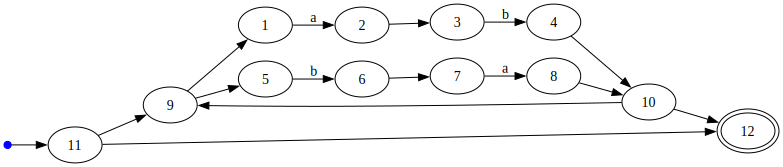

In [8]:
d = nfa2dot(nfa) 
d       

After having constructed a non-deterministic <span style="font-variant:small-caps;">Fsm</span> for the regular expression,
we convert it into a deterministic <span style="font-variant:small-caps;">Fsm</span>.

In [9]:
%run 01-NFA-2-DFA.ipynb

Version 1.0.5


In [10]:
%unload_ext nb_mypy

In [11]:
dfa = nfa2dfa(nfa) 
dfa

({frozenset(),
  frozenset({2, 3}),
  frozenset({6, 7}),
  frozenset({1, 5, 8, 9, 10, 12}),
  frozenset({1, 5, 9, 11, 12}),
  frozenset({1, 4, 5, 9, 10, 12})},
 {'a', 'b'},
 {(frozenset({2, 3}), 'a'): frozenset(),
  (frozenset({2, 3}), 'b'): frozenset({1, 4, 5, 9, 10, 12}),
  (frozenset({6, 7}), 'a'): frozenset({1, 5, 8, 9, 10, 12}),
  (frozenset({6, 7}), 'b'): frozenset(),
  (frozenset({1, 5, 8, 9, 10, 12}), 'a'): frozenset({2, 3}),
  (frozenset({1, 5, 8, 9, 10, 12}), 'b'): frozenset({6, 7}),
  (frozenset({1, 5, 9, 11, 12}), 'a'): frozenset({2, 3}),
  (frozenset({1, 5, 9, 11, 12}), 'b'): frozenset({6, 7}),
  (frozenset(), 'a'): frozenset(),
  (frozenset(), 'b'): frozenset(),
  (frozenset({1, 4, 5, 9, 10, 12}), 'a'): frozenset({2, 3}),
  (frozenset({1, 4, 5, 9, 10, 12}), 'b'): frozenset({6, 7})},
 frozenset({1, 5, 9, 11, 12}),
 {frozenset({1, 5, 8, 9, 10, 12}),
  frozenset({1, 5, 9, 11, 12}),
  frozenset({1, 4, 5, 9, 10, 12})})

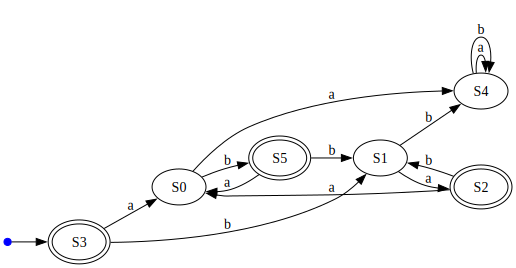

In [12]:
d, S = dfa2dot(dfa) 
d

Note that the resulting DFA is not minimal, since we can identify some states.

In [ ]:
d

In [1]:
// 04-Regexp-2-DFA-Test.ts
// TypeScript test of RegExp2NFA, NFA -> DFA conversion, and structure verification.
// Requires: regexp_to_nfa_final.ts (must be imported or in same file)

type State = number;
type Char = string;
const EPS = "ε";

// Reuse NFA type from previous file
interface NFA {
  Q: Set<State>;
  Sigma: Set<Char>;
  delta: Map<string, Set<State>>;
  q0: State;
  F: Set<State>;
}

// ---- Utility: epsilonClosure and step from NFA ----
function epsilonClosure(n: NFA, S: Set<State>): Set<State> {
  const stack = [...S];
  const visited = new Set(S);
  while (stack.length) {
    const q = stack.pop()!;
    const k = JSON.stringify([q, EPS]);
    const next = n.delta.get(k);
    if (!next) continue;
    for (const t of next) {
      if (!visited.has(t)) {
        visited.add(t);
        stack.push(t);
      }
    }
  }
  return visited;
}

function step(n: NFA, S: Set<State>, a: Char): Set<State> {
  const out = new Set<State>();
  for (const q of S) {
    const k = JSON.stringify([q, a]);
    const next = n.delta.get(k);
    if (next) for (const t of next) out.add(t);
  }
  return out;
}

// ---- NFA -> DFA Conversion ----

interface DFA {
  Q: Set<string>; // each state = stringified Set<State>
  Sigma: Set<Char>;
  delta: Map<string, string>; // from DFA-state+symbol to DFA-state
  q0: string;
  F: Set<string>;
}

function nfa2dfa(nfa: NFA): DFA {
  const Sigma = new Set([...nfa.Sigma]);
  const start = epsilonClosure(nfa, new Set([nfa.q0]));
  const startKey = keyOf(start);

  const Q = new Set<string>();
  const delta = new Map<string, string>();
  const F = new Set<string>();
  const queue: Set<State>[] = [start];
  const seen = new Set<string>([startKey]);

  while (queue.length) {
    const S = queue.shift()!;
    const Skey = keyOf(S);
    Q.add(Skey);

    // final if intersects with NFA.F
    if ([...S].some(s => nfa.F.has(s))) F.add(Skey);

    for (const a of Sigma) {
      const move = step(nfa, S, a);
      const U = epsilonClosure(nfa, move);
      const Ukey = keyOf(U);
      delta.set(JSON.stringify([Skey, a]), Ukey);
      if (!seen.has(Ukey)) {
        seen.add(Ukey);
        queue.push(U);
      }
    }
  }

  return { Q, Sigma, delta, q0: startKey, F };
}

function keyOf(S: Set<State>): string {
  return JSON.stringify([...S].sort((a, b) => a - b));
}

// ---- Pretty printer (simulating nfa2dot / dfa2dot) ----

function printAutomaton(
  label: string,
  Q: Set<any>,
  Sigma: Set<Char>,
  delta: Map<any, any>,
  q0: any,
  F: Set<any>
) {
  console.log(`\n--- ${label} ---`);
  console.log("States:", [...Q]);
  console.log("Alphabet:", [...Sigma]);
  console.log("Start:", q0);
  console.log("Finals:", [...F]);
  console.log("Transitions:");
  for (const [k, v] of delta) {
    console.log(" ", k, "→", v);
  }
}

// ---- Example from notebook ----
// (𝚊⋅𝚋+𝚋⋅𝚊)∗ == (ab+ba)*

const Sigma = new Set<Char>(["a", "b"]);
const conv = new RegExp2NFA(Sigma);

// Use your parser from regexp_to_nfa_final.ts
const r = parseRegex("(a.b+ b.a)*", Sigma);
console.log("Parsed RegExp:", JSON.stringify(r));

const nfa = conv.toNFA(r);
printAutomaton("NFA", nfa.Q, nfa.Sigma, nfa.delta, nfa.q0, nfa.F);

// Convert NFA -> DFA
const dfa = nfa2dfa(nfa);
printAutomaton("DFA", dfa.Q, dfa.Sigma, dfa.delta, dfa.q0, dfa.F);

// Optional: quick simulation check
function simulateDFA(dfa: DFA, input: string): boolean {
  let state = dfa.q0;
  for (const a of input) {
    state = dfa.delta.get(JSON.stringify([state, a])) ?? "[]";
  }
  return dfa.F.has(state);
}

console.log("\nTesting DFA acceptance:");
for (const w of ["", "ab", "ba", "abba", "abab", "baba", "aa"]) {
  console.log(`${w.padEnd(5)} → ${simulateDFA(dfa, w)}`);
}


120:18 - Cannot find name 'RegExp2NFA'.
123:11 - Cannot find name 'parseRegex'.
